In [1]:
import cv2
import numpy as np
import torch
import random
from PIL import Image
import matplotlib.pyplot as plt
import dlib
from scipy.spatial import procrustes
import os

from pytorch_lightning import seed_everything
from einops import rearrange
from annotator.util import resize_image, HWC3
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler
import config

## Helper functions

In [4]:
FACIAL_LANDMARKS_INDEXES = {
    "jaw": (0, 17),
    "right_eyebrow": (17, 22),
    "left_eyebrow": (22, 27),
    "nose_bridge": (27, 31),
    "lower_nose": (31, 36),
    "right_eye": (36, 42),
    "left_eye": (42, 48),
    "outer_lip": (48, 60),
    "inner_lip": (60, 68)
}

# Load dlib models once
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./models/shape_predictor_68_face_landmarks.dat")

def get_landmark_image(image: np.ndarray) -> np.ndarray:
    """
    Detect face and return an image with facial landmarks drawn.
    
    Parameters:
        image (np.ndarray): Input BGR image.
        
    Returns:
        landmark_img (np.ndarray): Image with landmarks drawn.
                                   If no face is found, returns None.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    landmark_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

    faces = detector(gray)
    if not faces:
        return None  # No face detected

    # Use the first detected face
    landmarks = predictor(gray, faces[0])

    for name, (start, end) in FACIAL_LANDMARKS_INDEXES.items():
        points = []
        for i in range(start, end):
            x, y = landmarks.part(i).x, landmarks.part(i).y
            points.append((x, y))

        is_closed = name in ["left_eye", "right_eye", "outer_lip", "inner_lip"]
        for j in range(len(points) - 1):
            cv2.line(landmark_img, points[j], points[j + 1], (255, 255, 255), 5)
        if is_closed:
            cv2.line(landmark_img, points[-1], points[0], (255, 255, 255), 5)

    return landmark_img


def extract_landmarks(img_np):
    # Convert to grayscale
    gray = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)

    # Detect face(s)
    faces = detector(gray)
    if len(faces) == 0:
        raise ValueError("No faces detected in the image.")
    
    # Use the first face
    shape = predictor(gray, faces[0])

    # Convert landmarks to numpy array
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])
    return landmarks

def compute_procrustes_similarity(img1, img2):
    lm1 = extract_landmarks(img1)
    lm2 = extract_landmarks(img2)

    # Procrustes analysis
    mtx1, mtx2, disparity = procrustes(lm1, lm2)

    # Similarity score
    similarity = 1 - disparity
    return similarity

## Loading Model

In [5]:
model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict('./models/model-epoch=02-step=21900.ckpt', location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/model-epoch=02-step=21900.ckpt]


## Specify input conditioning image and prompt

In [6]:
# Load your input image
input_img_number = 4587   #Change this number for any facial landmark in the dataset
prompt = "This lady has no bangs. She is a young adult and has no smile. There is not any glasses on the face." #change this to any prompt

In [7]:
input_path = './training/guided_face/source/' + str(input_img_number) + '.jpg'  
input_image = cv2.imread(input_path)
input_image = cv2.resize(input_image, (512, 512))
a_prompt = "best quality, extremely detailed"
n_prompt = "lowres, bad anatomy, worst quality"

## Generate Image

In [10]:
num_samples = 1
image_resolution = 512
ddim_steps = 50
guess_mode = False
strength = 1.0
scale = 9.0
seed = -1
eta = 0.0
low_threshold = 100
high_threshold = 200

# Processing logic
with torch.no_grad():
    img = resize_image(HWC3(input_image), image_resolution)
    H, W, C = img.shape
    detected_map = img

    control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
    control = torch.stack([control for _ in range(num_samples)], dim=0)
    control = rearrange(control, 'b h w c -> b c h w').clone()

    if seed == -1:
        seed = random.randint(0, 65535)
    seed_everything(seed)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=False)

    cond = {
        "c_concat": [control],
        "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]
    }
    un_cond = {
        "c_concat": None if guess_mode else [control],
        "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]
    }
    shape = (4, H // 8, W // 8)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=True)

    model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)

    samples, _ = ddim_sampler.sample(
        ddim_steps, num_samples, shape, cond, verbose=False, eta=eta,
        unconditional_guidance_scale=scale,
        unconditional_conditioning=un_cond
    )

    if config.save_memory:
        model.low_vram_shift(is_diffusing=False)

    x_samples = model.decode_first_stage(samples)
    x_samples = (rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

    # Save results
    for i, output_img in enumerate(x_samples):
        final_output_image = output_img
similarity = compute_procrustes_similarity(final_output_image, cv2.imread('./Data/RestructurePrompt/source/' + str(input_img_number) + '.jpg'))
final_output_image_landmark = get_landmark_image(final_output_image) 

Seed set to 41826


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


## Plotting outputs

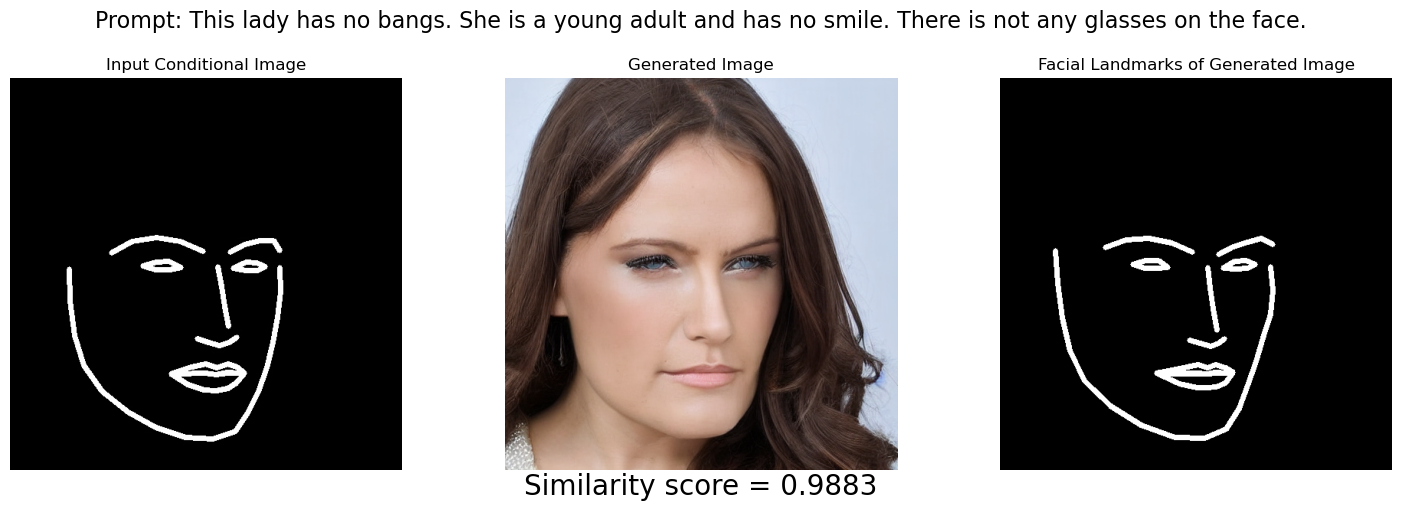

In [11]:
import matplotlib.pyplot as plt
import cv2

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(input_image)
axs[0].axis('off')
axs[0].set_title('Input Conditional Image')

axs[1].imshow(final_output_image)
axs[1].axis('off')
axs[1].set_title('Generated Image')

axs[2].imshow(final_output_image_landmark)
axs[2].axis('off')
axs[2].set_title('Facial Landmarks of Generated Image')

# Add top caption
plt.suptitle('Prompt: ' + prompt, fontsize=16)

# Add bottom caption
plt.figtext(0.5, 0.01, f"Similarity score = {similarity:.4f}", 
            ha='center', fontsize=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle and figtext
plt.show()
